a quickstart on using python apis for `s3d` model

original c code: https://github.com/peterfennell/S3D

---

In [61]:
import utils
import pandas as pd

In [62]:
from pys3d import PYS3D

In [63]:
import matplotlib.colors as mc
from matplotlib import pyplot as plt
%matplotlib inline

---

#### clarification

the design of the constructor is meant to be easy for hyperparameter tuning by cross validation. therefore, the methods `fit` and `predict` may be a little weird to use as standalone functions.

##### python dependencies

- `pandas`
- `joblib`
- `networkx` (the latest version has the edge arrow fixed!)
- `matplotlib`
- `scikit-learn`
- `seaborn`
- `palettable`

these can be installed by:
```bash
pip install -r requirements.txt
```

##### compiling `s3d`

compiling is simple and straight forward, do:
```bash
make all
```
or 
```bash
make clean && make all
```
to remove previous compiled files.

##### data for cross val

for cross validation processes, datasets should be splitted first. the script `split_data.py` can be used to do so. the script can be run as the following:
```python
python split_data.py data_name num_folds
```

this will read in `data_name.csv` from `data/` folder; split data and store the train/test sets into `splitted_data/data_name/` folder. for example, if there is a dataset called `breastcancer.csv` in `data/`, we can do:
```bash
python split_data.py breastcancer 5
```

if we do `ls splitted_data/breastcancer/`, we will see:
```bash
0  1  2  3  4
```
which are fold indices named folder, each of which there will be:
```bash
num_rows.csv  test.csv  train.csv
```

`train.csv` is the training set; `test.csv` is the testing set; `num_rows.csv` store the number of rows in train/test respectively.

finally, you can parallelize the data partitioning with more cores:
```bash
ptyhon split_data.py data_name num_folds num_jobs
```

where `num_jobs` is 1 by default.

##### data format

data format: in `data_name.csv`, the first column is the target column named `target`, followed by features:
> `target,feature_1,feature_2,...,feature_p`

##### file structure

file directory setup: `PYS3D` class will by default create subfodlers `data_name` in:
```bash
tmp/ predictions/ models/ cv/
```

where:
- `tmp` will store the "inner cross validation" temporary files
- `predictions` will store the prediction results
- `models` will store the trained models
- `cv` will store the cross validation performance (on the validation set)

therefore, the first step is to create all these 4 for your convenience. you can do:
```bash
./init
```
which will cleanup and create these folders

reversely, run `./cleanup` to remove these folders

##### example datasets

the two datasets both come from [uci machine learning repository](https://archive.ics.uci.edu/ml/index.php)
- breacancer: [link](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29)
- bike sharing: hourly [link](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

---

#### create `s3d` model

suppose the dataset is stored at `../splitted_data/`, all we need for the model is the name of the dataset of interest

In [8]:
help(PYS3D.__init__)

Help on function __init__ in module pys3d:

__init__(self, data_name, data_path='../splitted_data/', model_path='models/', prediction_path='predictions/', classification_flag=True)
    initializer
    
    parameters
    ----------
    data_name : str
        intput data name
    data_path : str
        input data base path
    model_path : str
        base path for output of built models
    prediction_path : str
        base path for predicted expectations
    classification_flag : bool
        whether this is classification or regression. tihis is used for determining evaluation metrics
    
    for each path, we assume that there are sub folders for each test fold



In [9]:
data_name = 'breastcancer'
fold_index = 1

In [10]:
%%bash
./cleanup
./init

tmp not exist, create
models not exist, create
predictions not exist, create
cv not exist, create


In [11]:
s3d = PYS3D(data_name)

...s3d initializing...
s3d with breastcancer data, splitted into 5 folds
data will be loaded from ../splitted_data/breastcancer/
built models will be saved to models/breastcancer/
predictions will be saved to predictions/breastcancer/
temporary subfolders in  ./tmp/breastcancer
...done initializing...



section 3 and 4 describes the typical training/testing process for one of the folds

section 5 starts to 

---

#### train

there are two required input arg:
- `train_data_path`: the path to the dataset. assume that the target is in the first column 
- `train_model_path`: the path to save the model

In [12]:
train_data = '../splitted_data/{}/{}/train.csv'.format(data_name, fold_index)
train_model = 'test-folder/'

In [13]:
s3d.fit(train_data, train_model, lambda_=0.001, max_features=5)

the outputs will be saved to `test-folder/` in our case

---

#### visualize the trained model

##### steps

we can visualize chosen features at each step and the unique contribution of $r^2$

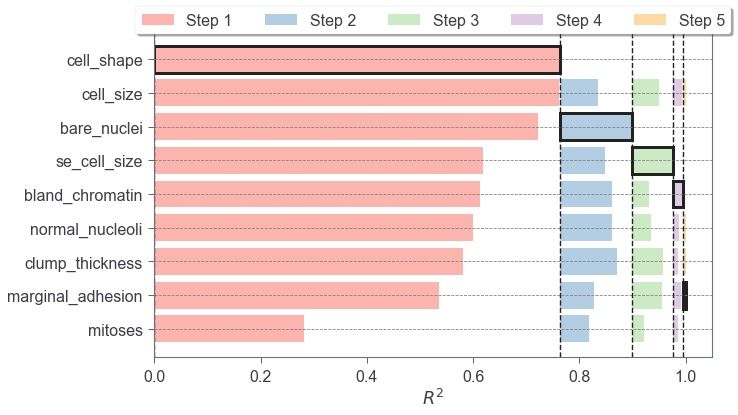

In [14]:
fig, ax = utils.visualize_s3d_steps(train_model, figsize=(10,6))

##### feature binning

sometimes customization needed to improve the overall quality

In [64]:
pink_color = '#FBB4AE'
my_cmap = mc.LinearSegmentedColormap.from_list('custom_pink', ['#ffffff', pink_color], N=256)

first calll `utils.visualize_s3d_model_reader` to obtain _bins_. 3 required inputs:
- `model_folder`: `train_model` in our case
- `dim`: how many feature to use (2, 3, or 4)
- `thres`: classification threhold

In [16]:
dim = 3
thres = 0.33

In [17]:
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, thres)

we can plot the heatmap for 3 types of data:
- frequency: the frequency of data points - use `N_dim`
- y bar: $E[y]$, the expected targat values - use `intensity_dim`
- prediction: predicted class/label - use `pred_dim`

###### frequency

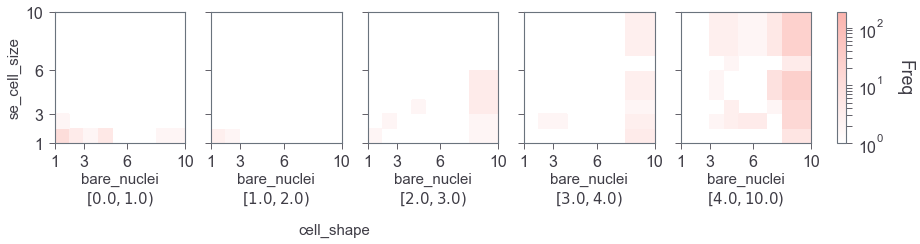

In [18]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap, 
                                        N_dim, 'Freq', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                        norm_func=mc.LogNorm
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

###### expected value

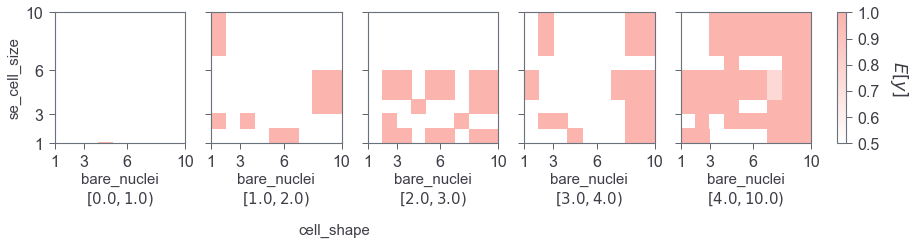

In [19]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap, 
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

###### predictions

for this, a more customized discrete colormap is recommended

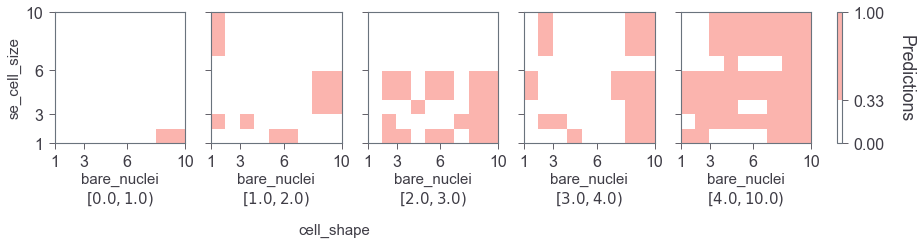

In [20]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, 
                                        mc.ListedColormap(['white'] + [pink_color]*int(round(1/thres-1))), 
                                        pred_dim, 'Predictions', chosen_f_dim, 
                                        xscale='linear', yscale='linear', 
                                        cb_kwargs={'aspect':30, 'ticks': [0, thres, 1]}
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

##### feature network

we can also visualize the redundancy between features:
- node: features
- edge
    - direction: from thee unselected feature ($X_j$) to the selected one ($X_l$)
    - width: "variation redundancies" of $X_j$ made by selecting $X_l$:
        $$a_{X_j,X_l^S}=\Delta R^2(P_{X_j}|\mathcal{P}^{S(l-1)}) - \Delta R^2(P_{X_j}|\mathcal{P}^{S(l-1)}\times P_{X_l^S})$$
- color: distinguish selected/unselected (and maybe isolated those w/o much contribution to the target)

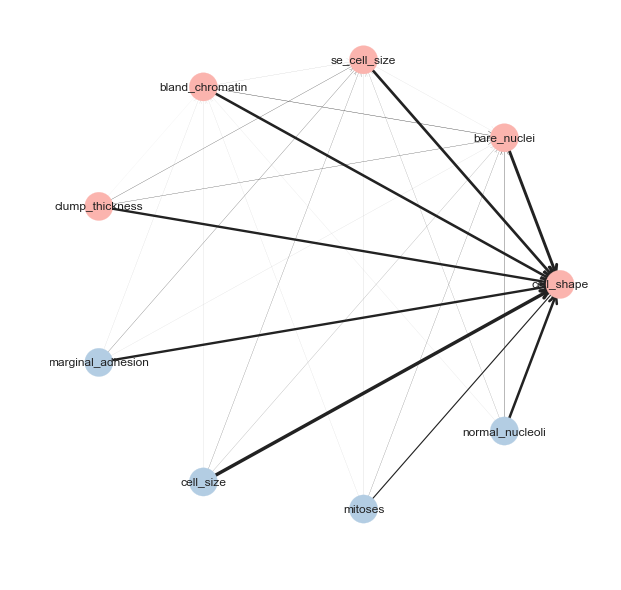

In [21]:
net, (fig, ax) = utils.visualize_feature_network(model_folder=train_model, w_scale=5)

---

#### hyperparameter tuning

it is convenient to tune the hyperparameters: 
- $\lambda$: regularization strength
- number of features: number of features to use (we like parsimonious models!)

the function to call is `pys3d.cross_val`:

In [22]:
help(s3d.cross_val)

Help on method cross_val in module pys3d:

cross_val(lambda_list, max_features, thres=0.5, calc_threshold=True) method of pys3d.PYS3D instance
    grid search for hyperparameters for each fold



the required input are $\lambda$'s and numbers of features

from the above figure, we see the 5th feature really contributes very little, so let's set the maximum features to be 4

In [23]:
lambda_list = [0.001, 0.003, 0.0001, 0.0003]
num_features = 4
data_name

'breastcancer'

In [24]:
s3d = PYS3D(data_name)

...s3d initializing...
s3d with breastcancer data, splitted into 5 folds
data will be loaded from ../splitted_data/breastcancer/
built models will be saved to models/breastcancer/
predictions will be saved to predictions/breastcancer/
temporary subfolders in  ./tmp/breastcancer
...done initializing...



In [25]:
s3d.cross_val(lambda_list, num_features, calc_threshold=True)

--- cross validation on breastcancer data ---
starting on fold 0


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


finish after 1.86 seconds
starting on fold 1
finish after 1.74 seconds
starting on fold 2
finish after 1.89 seconds
starting on fold 3
finish after 1.75 seconds
starting on fold 4
finish after 1.68 seconds
--- done cv; total elapsed time 8.94 seconds


the resulting file will be at `cv/data_name/performance.csv`

In [26]:
cv_df = pd.read_csv('cv/{}/performance.csv'.format(data_name))
cv_df.head(2)

,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,num_features,test_fold_i,train_r2,lambda_,max_features,split_version
0,0.948529,0.982812,0.982812,0.940171,0.947505,0.948529,0.787500,0.382353,1,0,0.755441,0.001,4,0
1,0.963235,0.966853,0.966853,0.956522,0.962337,0.963235,0.848214,0.571429,2,0,0.889637,0.001,4,0


we can further visualize the train/validation performance, which also returns:
- the best number of features and $\lambda$
- as well as the value of the given metric (by default it uses [`auc micro`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score))

__note that we need to specify which split to be analyzed - different splits may have slightly different hyperparams__

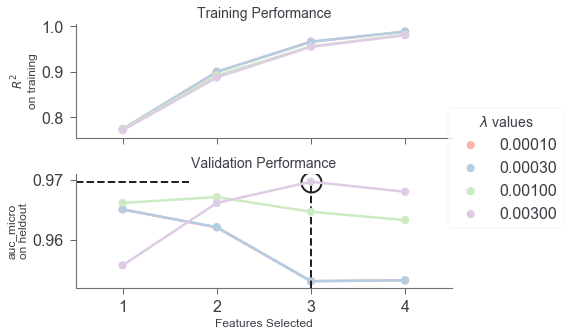

In [27]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         split_version=0)

In [28]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

for split version 0...
best number of features: 3.0
best lambda: 0.003


change the metric to accuracy; check out a different fold

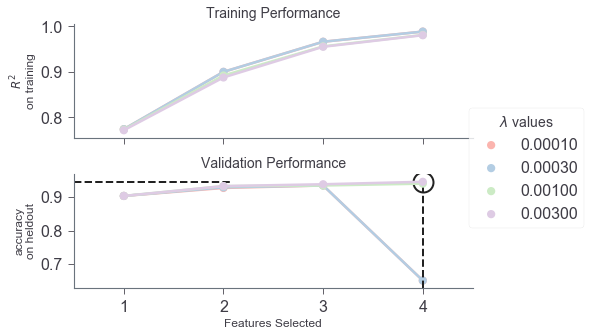

In [29]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         validation_metric='accuracy',
                                                                         split_version=0,
                                                                        )

In [30]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

for split version 0...
best number of features: 4.0
best lambda: 0.003


---

#### multi core hyperparam tuning

if more computing resources are available, we can parallelize different folds

In [31]:
s3d.cross_val_multicore(lambda_list, num_features, calc_threshold=True, num_cores=5)

--- cross validation (5 cores) on breastcancer data ---


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

--- done multi-core cv; total elapsed time 4.19 seconds


checkout the cross val for `fold_index`

In [32]:
fold_index

1

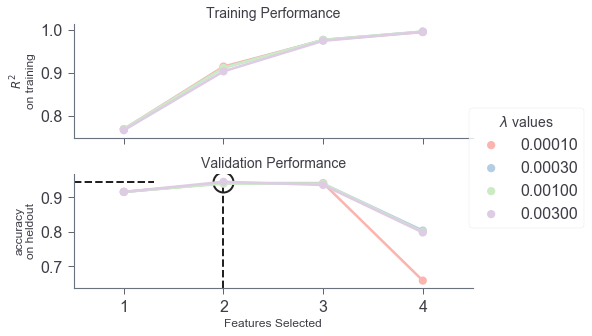

In [33]:
fp, best_n_f, best_val, best_lambda_, split_version = utils.visualize_cv('cv/{}/performance.csv'.format(data_name), 
                                                                         split_version=fold_index,
                                                                         validation_metric='accuracy')

In [34]:
print('for split version {}...\nbest number of features: {}\nbest lambda: {}'.format(split_version, best_n_f, best_lambda_))

for split version 1...
best number of features: 2.0
best lambda: 0.003


---

#### predict (for one fold)

we can then use the trained model to predict for the held-out set; let's pick
- $\lambda=0.03$
- $num\_features=2$

train the model again with "the best hyperparameters"

In [35]:
s3d = PYS3D(data_name)
s3d.fit(train_data, train_model, lambda_=best_lambda_, max_features=best_n_f)

...s3d initializing...
s3d with breastcancer data, splitted into 5 folds
data will be loaded from ../splitted_data/breastcancer/
built models will be saved to models/breastcancer/
predictions will be saved to predictions/breastcancer/
temporary subfolders in  ./tmp/breastcancer
...done initializing...



check out the feature binning

In [36]:
thres = s3d.calculate_disc_threshold(train_model, best_n_f)
thres

0.75

In [37]:
dim = best_n_f
dim, thres

(2.0, 0.75)

In [38]:
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, int(dim), thres)

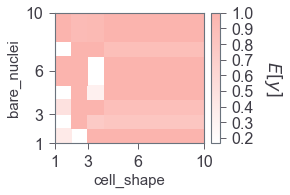

In [39]:
fig, ax_arr = utils.visualize_s3d_model(int(dim), splits_at_dim, my_cmap, 
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

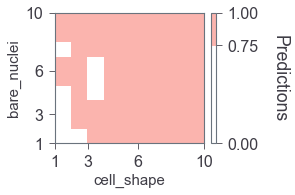

In [40]:
fig, ax_arr = utils.visualize_s3d_model(int(dim), splits_at_dim, 
                                        mc.ListedColormap(['white']*3 + [pink_color]), 
                                        pred_dim, 'Predictions', chosen_f_dim, 
                                        xscale='linear', yscale='linear', 
                                        cb_kwargs={'aspect':30, 'ticks': [0, thres, 1]}
                                       )
ax_arr[0,0].set_xticks([1,3,6,10])
ax_arr[0,0].set_yticks([1,3,6,10])
ax_arr[0,0].minorticks_off()

prediction

In [41]:
test_data = '../splitted_data/{}/{}/test.csv'.format(data_name, fold_index)
prediction_path = 'test-folder/'
s3d.predict(test_data, train_model, prediction_path)

note that this will be done when the number of features used for prediction vary from 1 to `k`, which is the largest number of features found by the training process

In [42]:
ls test-folder/

N_tree.csv                       predict_MF_2.log
R2improvements.csv               predicted_expectations_MF_1.csv
fit.log                          predicted_expectations_MF_2.csv
levels.csv                       splits.csv
predict_MF_1.log                 ybar_tree.csv


---

#### score (for one fold)

or we can directly obtain the performance scores by `score` function

In [43]:
train_data

'../splitted_data/breastcancer/1/train.csv'

In [44]:
test_data

'../splitted_data/breastcancer/1/test.csv'

In [45]:
s3d.score(test_data, train_model, prediction_path)

,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,num_features
0,0.927007,0.983146,0.983146,0.891304,0.918180,0.927007,0.679307,0.5,1
1,0.978102,0.999532,0.999532,0.969697,0.976277,0.978102,0.903792,0.5,2


by default, the threshold is 0.5. we can change it

In [46]:
s3d.score(test_data, train_model, prediction_path, thres=0.4)

,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,num_features
0,0.927007,0.983146,0.983146,0.90566,0.923068,0.927007,0.679307,0.4,1
1,0.970803,0.999532,0.999532,0.96000,0.968506,0.970803,0.871723,0.4,2


given `train_data_path` and `calc_threshold`, the prediction threshold will be determined by the class distribution in training set

In [47]:
s3d.score(test_data, train_model, prediction_path, 
          train_data_path=train_data, calc_threshold=True)

threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features


,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,num_features
0,0.927007,0.983146,0.983146,0.905660,0.923068,0.927007,0.679307,0.488889,1
1,0.992701,0.999532,0.999532,0.989691,0.992021,0.992701,0.967931,0.750000,2


---

#### test for each fold

finally, we can find the best parameter sets for individual (outer) folds. The trained (best) model will be applied to each of the test folds.

##### best params for each fold

we can see the best parameter sets using `utils.find_best_param()`, given different evaluation metric

In [48]:
utils.find_best_param(performance_file='cv/{}/performance.csv'.format(data_name),  
                      validation_metric='accuracy')

,split_version,lambda_,num_features,best_value,metric
0,0,0.003,4,0.945081,accuracy
1,1,0.003,2,0.945054,accuracy
2,2,0.003,2,0.948717,accuracy
3,3,0.003,2,0.935863,accuracy
4,4,0.003,2,0.954380,accuracy


In [49]:
utils.find_best_param(performance_file='cv/{}/performance.csv'.format(data_name),  
                      validation_metric='auc_micro')

,split_version,lambda_,num_features,best_value,metric
0,0,0.0030,3,0.969664,auc_micro
1,1,0.0030,1,0.967763,auc_micro
2,2,0.0030,1,0.967646,auc_micro
3,3,0.0010,1,0.967278,auc_micro
4,4,0.0003,1,0.969818,auc_micro


##### evaluation of s3d

instead of running evaluation for each fold seperately, we can actually evaluate s3d on the test hold with 2 api calls:
1. use `s3d.cross_val()` or `s3d.cross_val_multicore()` to obtain performance on validation sets. this will export `cv/data_name/performance.csv` that can be used for parameter tuninig
2. then we can run `s3d.evaluate()` to obtain ___test performance___, given a `cv_metric` that determines the "best parameters". if multiple cores are available, we can set `num_jobs` to speed up the whole process.

In [50]:
s3d.evaluate(num_jobs=2)

evaluating s3d model using 2 cores...
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features
threshold based on trianing set: 0.5 for 3 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.488889 for 1 features


,num_features,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,lambda_,split_version
0,3,0.992701,0.989583,0.989583,0.989474,0.991944,0.992701,0.967931,0.500000,0.0030,0.0
1,1,0.927007,0.983146,0.983146,0.905660,0.923068,0.927007,0.679307,0.488889,0.0030,1.0
2,1,0.868613,0.976826,0.976826,0.839286,0.864087,0.868613,0.422753,0.488889,0.0030,2.0
3,1,0.941606,0.960323,0.960323,0.916667,0.935861,0.941606,0.743446,0.488889,0.0010,3.0
4,1,0.925926,0.980174,0.980174,0.900000,0.920588,0.925926,0.673598,0.488889,0.0003,4.0


In [51]:
s3d.evaluate(num_jobs=2, cv_metric='accuracy')

evaluating s3d model using 2 cores...
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features
threshold based on trianing set: 0.5 for 3 features
threshold based on trianing set: 0.666667 for 4 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.75 for 2 features
threshold based on trianing set: 0.488889 for 1 features
threshold based on trianing set: 0.5 for 2 features


,num_features,accuracy,auc_macro,auc_micro,f1_binary,f1_macro,f1_micro,r2,threshold,lambda_,split_version
0,4,0.992701,0.989583,0.989583,0.989474,0.991944,0.992701,0.967931,0.666667,0.003,0.0
1,2,0.992701,0.999532,0.999532,0.989691,0.992021,0.992701,0.967931,0.750000,0.003,1.0
2,2,0.970803,0.996255,0.996255,0.958333,0.967931,0.970803,0.871723,0.750000,0.003,2.0
3,2,0.948905,0.987711,0.987711,0.926316,0.943605,0.948905,0.775515,0.750000,0.003,3.0
4,2,0.955556,0.986098,0.986098,0.938776,0.951946,0.955556,0.804159,0.500000,0.003,4.0


---

#### regression

finally, it is noteworthy that we can do regression. the only change we need to do is to set `classification_flag` in the constructor as `False`

In [52]:
reg_s3d = PYS3D('bike', classification_flag=False)

...s3d initializing...
s3d with bike data, splitted into 5 folds
data will be loaded from ../splitted_data/bike/
built models will be saved to models/bike/
predictions will be saved to predictions/bike/
temporary subfolders in  ./tmp/bike
...done initializing...



##### cross validation

just as classifications, we will 
- first call `s3d.cross_val()` to get validation performance; 
- then `s3d.evaluate()` to get the performance on the test fold

In [53]:
lambda_list = [0.001, 0.003, 0.0001, 0.0003]
num_features = 4
reg_s3d.cross_val_multicore(lambda_list, num_features, 
                            num_cores=4,
                            calc_threshold=False)

--- cross validation (4 cores) on bike data ---
--- done multi-core cv; total elapsed time 52.59 seconds


note that the error values are manually set to negative for consistency of code - max values $\rightarrow$ best parameters

In [54]:
utils.find_best_param('cv/bike/performance.csv', 'r2')

,split_version,lambda_,num_features,best_value,metric
0,0,0.0030,4,0.839033,r2
1,1,0.0003,4,0.837515,r2
2,2,0.0030,4,0.843817,r2
3,3,0.0030,4,0.839848,r2
4,4,0.0030,4,0.850611,r2


In [55]:
reg_s3d.evaluate(num_jobs=4)

evaluating s3d model using 4 cores...


,num_features,mae,mae_median,mse,r2,lambda_,split_version
0,4,-44.533529,-27.8180,-4350.769730,0.859799,0.0030,0.0
1,4,-36.504276,-20.1333,-3606.165727,0.867493,0.0003,1.0
2,4,-48.087811,-29.4072,-5062.786120,0.888158,0.0030,2.0
3,4,-45.438856,-27.9630,-4488.802853,0.804949,0.0030,3.0
4,4,-46.214040,-29.1550,-4708.371360,0.869059,0.0030,4.0


##### visualization

similar visualization as previous ones

In [56]:
train_model = 'models/bike/0/'
dim = 2

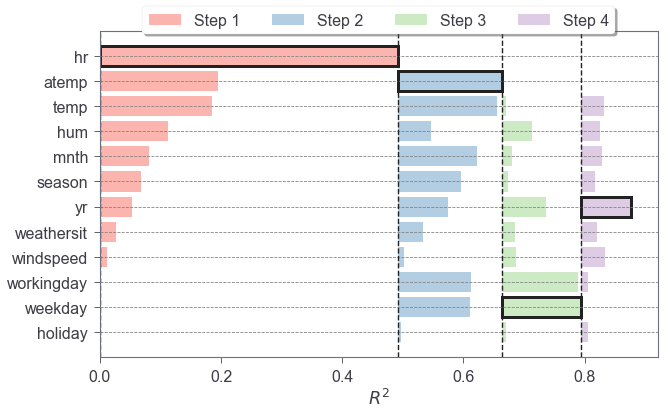

In [57]:
fig, ax = utils.visualize_s3d_steps(train_model, figsize=(10,6))

In [58]:
splits_at_dim, N_dim, intensity_dim, pred_dim, chosen_f_dim = utils.visualize_s3d_model_reader(train_model, dim, 0)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


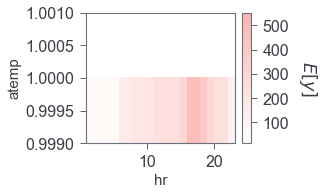

In [59]:
fig, ax_arr = utils.visualize_s3d_model(dim, splits_at_dim, my_cmap,
                                        intensity_dim, '$E[y]$', chosen_f_dim, 
                                        xscale='linear', yscale='linear',
                                       )
#ax_arr[0,0].set_xticks([1,3,6,10])
#ax_arr[0,0].set_yticks([1,3,6,10])
#ax_arr[0,0].minorticks_off()

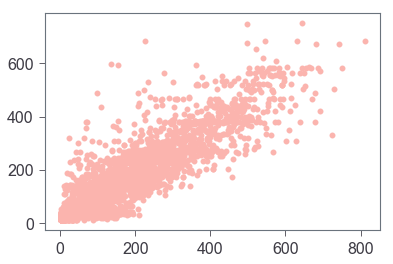

In [60]:
y_pred = pd.np.loadtxt('predictions/bike/3/predicted_expectations_MF_4.csv')
y_true = pd.read_csv('../splitted_data/bike/3/test.csv')['target'].values

plt.scatter(y_true, y_pred, color=pink_color)

---